In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from pandas import Timestamp
warnings.filterwarnings("ignore")


import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
from matplotlib import rc 
import plotly.express as px
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)


rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
# df = pd.read_csv('df.csv')

# dfVnavg_V = df[['Time','Vnavg_V']]

# def hourly_time(df):
#     # Convert the "Time" column to datetime format
#     df['Time'] = pd.to_datetime(df['Time'])
    
#     df.sort_values(by='Time', inplace=True)

#     # Set the "Time" column as the index
#     df.set_index('Time', inplace=True)

#     # Resample the DataFrame on an hourly basis and take the average of "Vnavg_V"
#     hourly_df = df.resample('H').mean()

#     # Reset the index to include the hourly timestamps
#     hourly_df.reset_index(inplace=True)

#     return hourly_df


# dfVnavg_V_Hourly = hourly_time(dfVnavg_V)
# dfVnavg_V_Hourly

In [ ]:
# # import pandas as pd
# df = pd.read_csv('df.csv')

# dfVnavg_V = df[['Time','Vnavg_V']]


# def thirty_minute_interval(df):
#     # Convert the "Time" column to datetime format
#     df['Time'] = pd.to_datetime(df['Time'])
#     df.sort_values(by='Time', inplace=True)
    

#     # Set the "Time" column as the index
#     df.set_index('Time', inplace=True)

#     # Resample the DataFrame on a 30-minute basis and take the average of "Vnavg_V"
#     interval_df = df.resample('30T').mean()

#     # Reset the index to include the 30-minute timestamps
#     interval_df.reset_index(inplace=True)

#     return interval_df

# dfVnavg_V_30T = thirty_minute_interval(dfVnavg_V)
# dfVnavg_V_30T

In [ ]:
dfVnavg_V_30T = pd.read_csv('dfVnavg_V_30T.csv')
dfVnavg_V_30T

,Time,Vnavg_V
0,2021-01-02 19:00:00,240.205875
1,2021-01-02 19:30:00,240.824333
2,2021-01-02 20:00:00,241.653033
3,2021-01-02 20:30:00,243.980533
4,2021-01-02 21:00:00,242.018600
...,...,...
40796,2023-05-02 17:00:00,236.663433
40797,2023-05-02 17:30:00,237.181800
40798,2023-05-02 18:00:00,236.687933
40799,2023-05-02 18:30:00,236.993567


In [ ]:
dfVnavg_V_30T['Vnavg_V'].fillna(dfVnavg_V_30T.Vnavg_V.mean(), inplace=True)

In [ ]:
dfVnavg_V_30T['Vnavg_V'].min()

210.0389

In [ ]:
# dfVnavg_V_30T_I = dfVnavg_V_30T.set_index('Time')
# plt.plot(dfVnavg_V_30T_I, label='Vnavg_V')
# plt.legend();

In [ ]:
import plotly.express as px


dfVnavg_V_30T['Time'] = pd.to_datetime(dfVnavg_V_30T['Time'])

# Use iplot to visualize the data
fig = px.line(dfVnavg_V_30T, x='Time', y='Vnavg_V', title='Vnavg_V over Time')
fig.show()

Standard Scaling

In [ ]:
train_size = int(len(dfVnavg_V_30T) * 0.95)
test_size = len(dfVnavg_V_30T) - train_size
train, test = dfVnavg_V_30T.iloc[0:train_size], dfVnavg_V_30T.iloc[train_size:len(dfVnavg_V_30T)]
print(train.shape, test.shape)


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['Vnavg_V']])

train['Vnavg_V'] = scaler.transform(train[['Vnavg_V']])
test['Vnavg_V'] = scaler.transform(test[['Vnavg_V']])
     
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['Vnavg_V']], train.Vnavg_V, TIME_STEPS)
X_test, y_test = create_dataset(test[['Vnavg_V']], test.Vnavg_V, TIME_STEPS)

print(X_train.shape)
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=128, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=128, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')




history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=200,
    validation_split=0.1,
    shuffle=False
)

(38760, 2) (2041, 2)
(38730, 30, 1)
Epoch 1/10
175/175 [==============================] - 62s 319ms/step - loss: 0.7023 - val_loss: 0.5143
Epoch 2/10
175/175 [==============================] - 54s 308ms/step - loss: 0.6974 - val_loss: 0.5165
Epoch 3/10
175/175 [==============================] - 53s 304ms/step - loss: 0.6965 - val_loss: 0.5270
Epoch 4/10
175/175 [==============================] - 54s 307ms/step - loss: 0.6968 - val_loss: 0.5368
Epoch 5/10
175/175 [==============================] - 59s 335ms/step - loss: 0.6971 - val_loss: 0.5598
Epoch 6/10
175/175 [==============================] - 54s 310ms/step - loss: 0.6977 - val_loss: 0.5892
Epoch 7/10
175/175 [==============================] - 59s 341ms/step - loss: 0.6994 - val_loss: 0.5614
Epoch 8/10
175/175 [==============================] - 62s 352ms/step - loss: 0.6979 - val_loss: 0.5707
Epoch 9/10
175/175 [==============================] - 57s 324ms/step - loss: 0.7011 - val_loss: 0.5945
Epoch 10/10
175/175 [================

In [ ]:
# y_hat = model.predict(X_test)
# y_hat.reshape(-1,30)
# y_hat.shape

# model.evaluate(X_test,y_test)

PLOT THE LOSS VS ECPOCHS

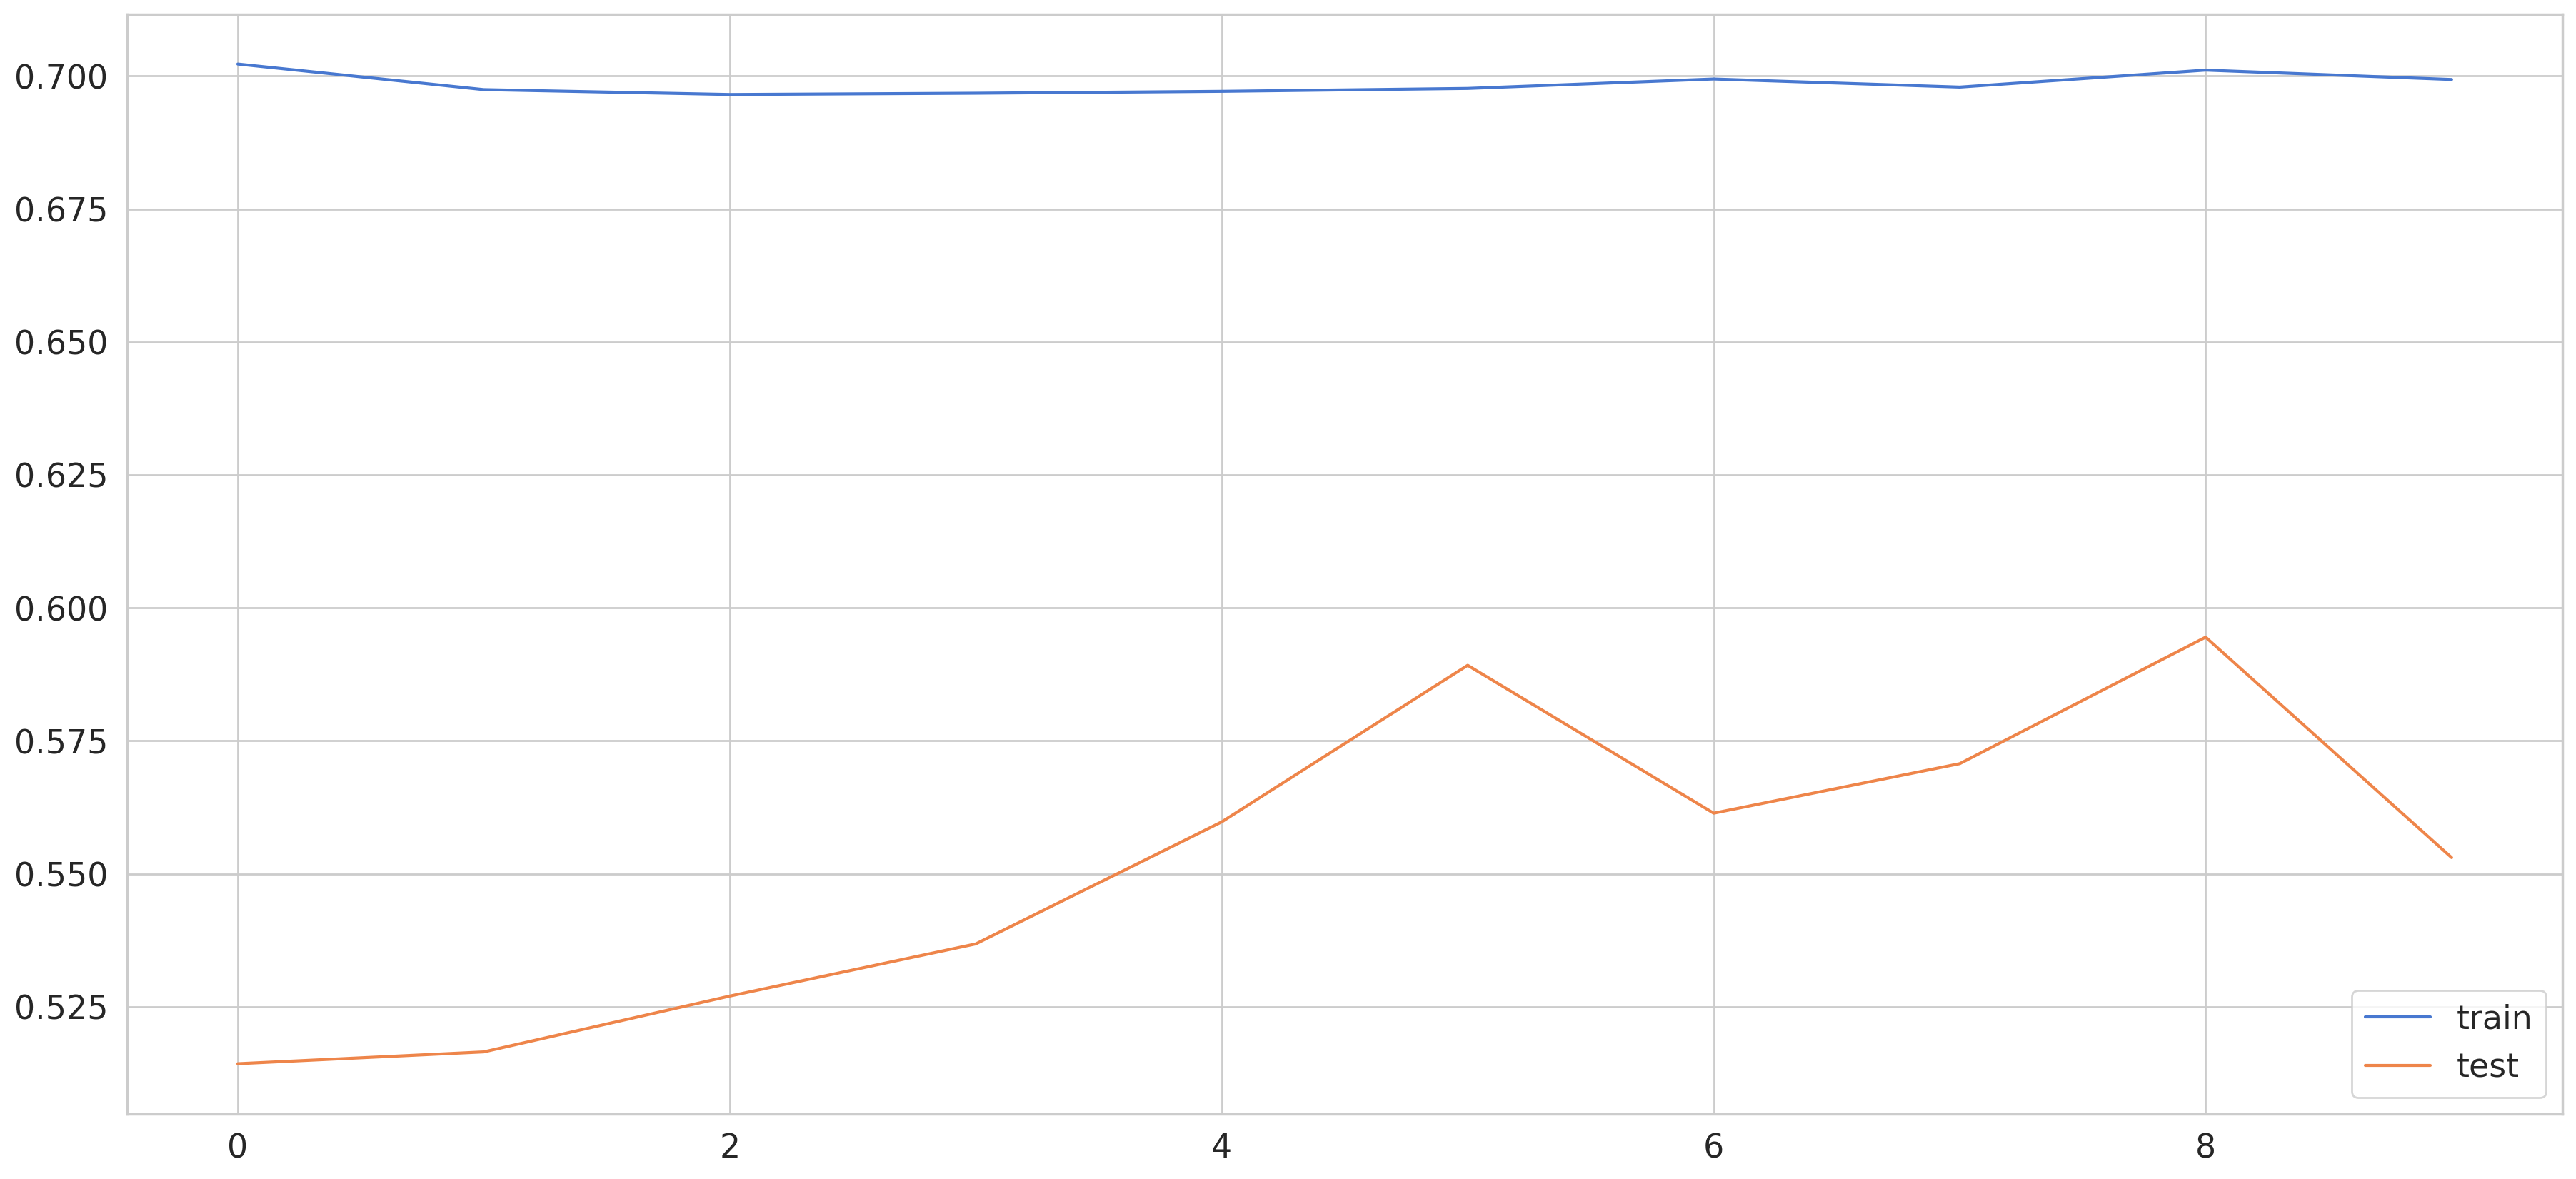

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

CALC LOSS BETWEEN yPred - yTest

In [ ]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

1211/1211 [==============================] - 47s 38ms/step


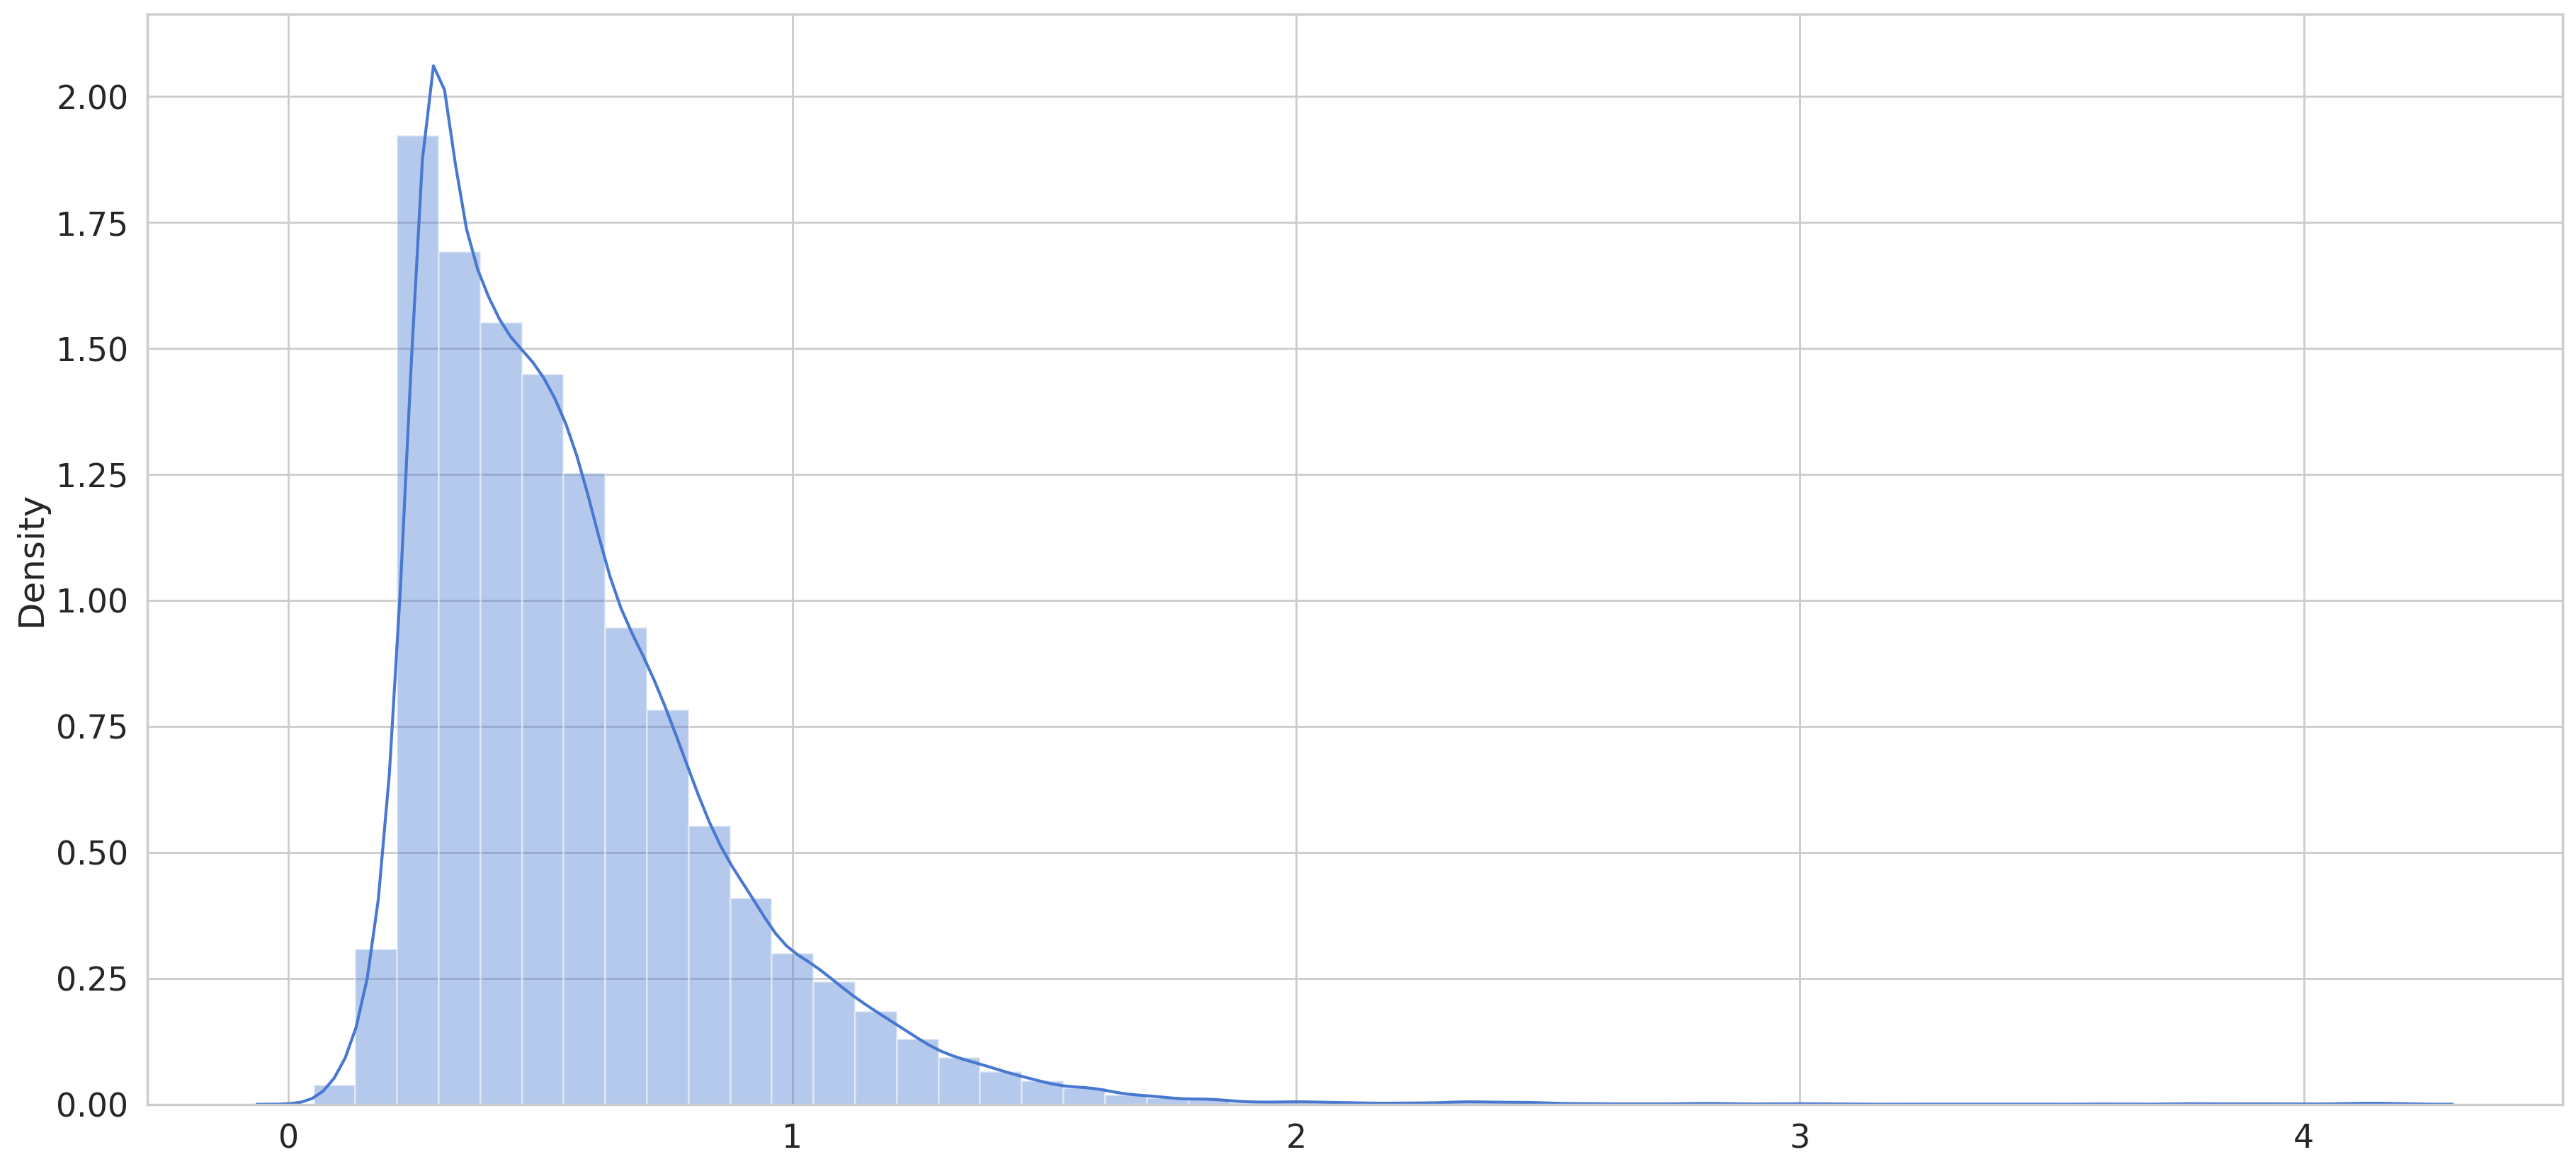

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [ ]:

X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

63/63 [==============================] - 2s 31ms/step


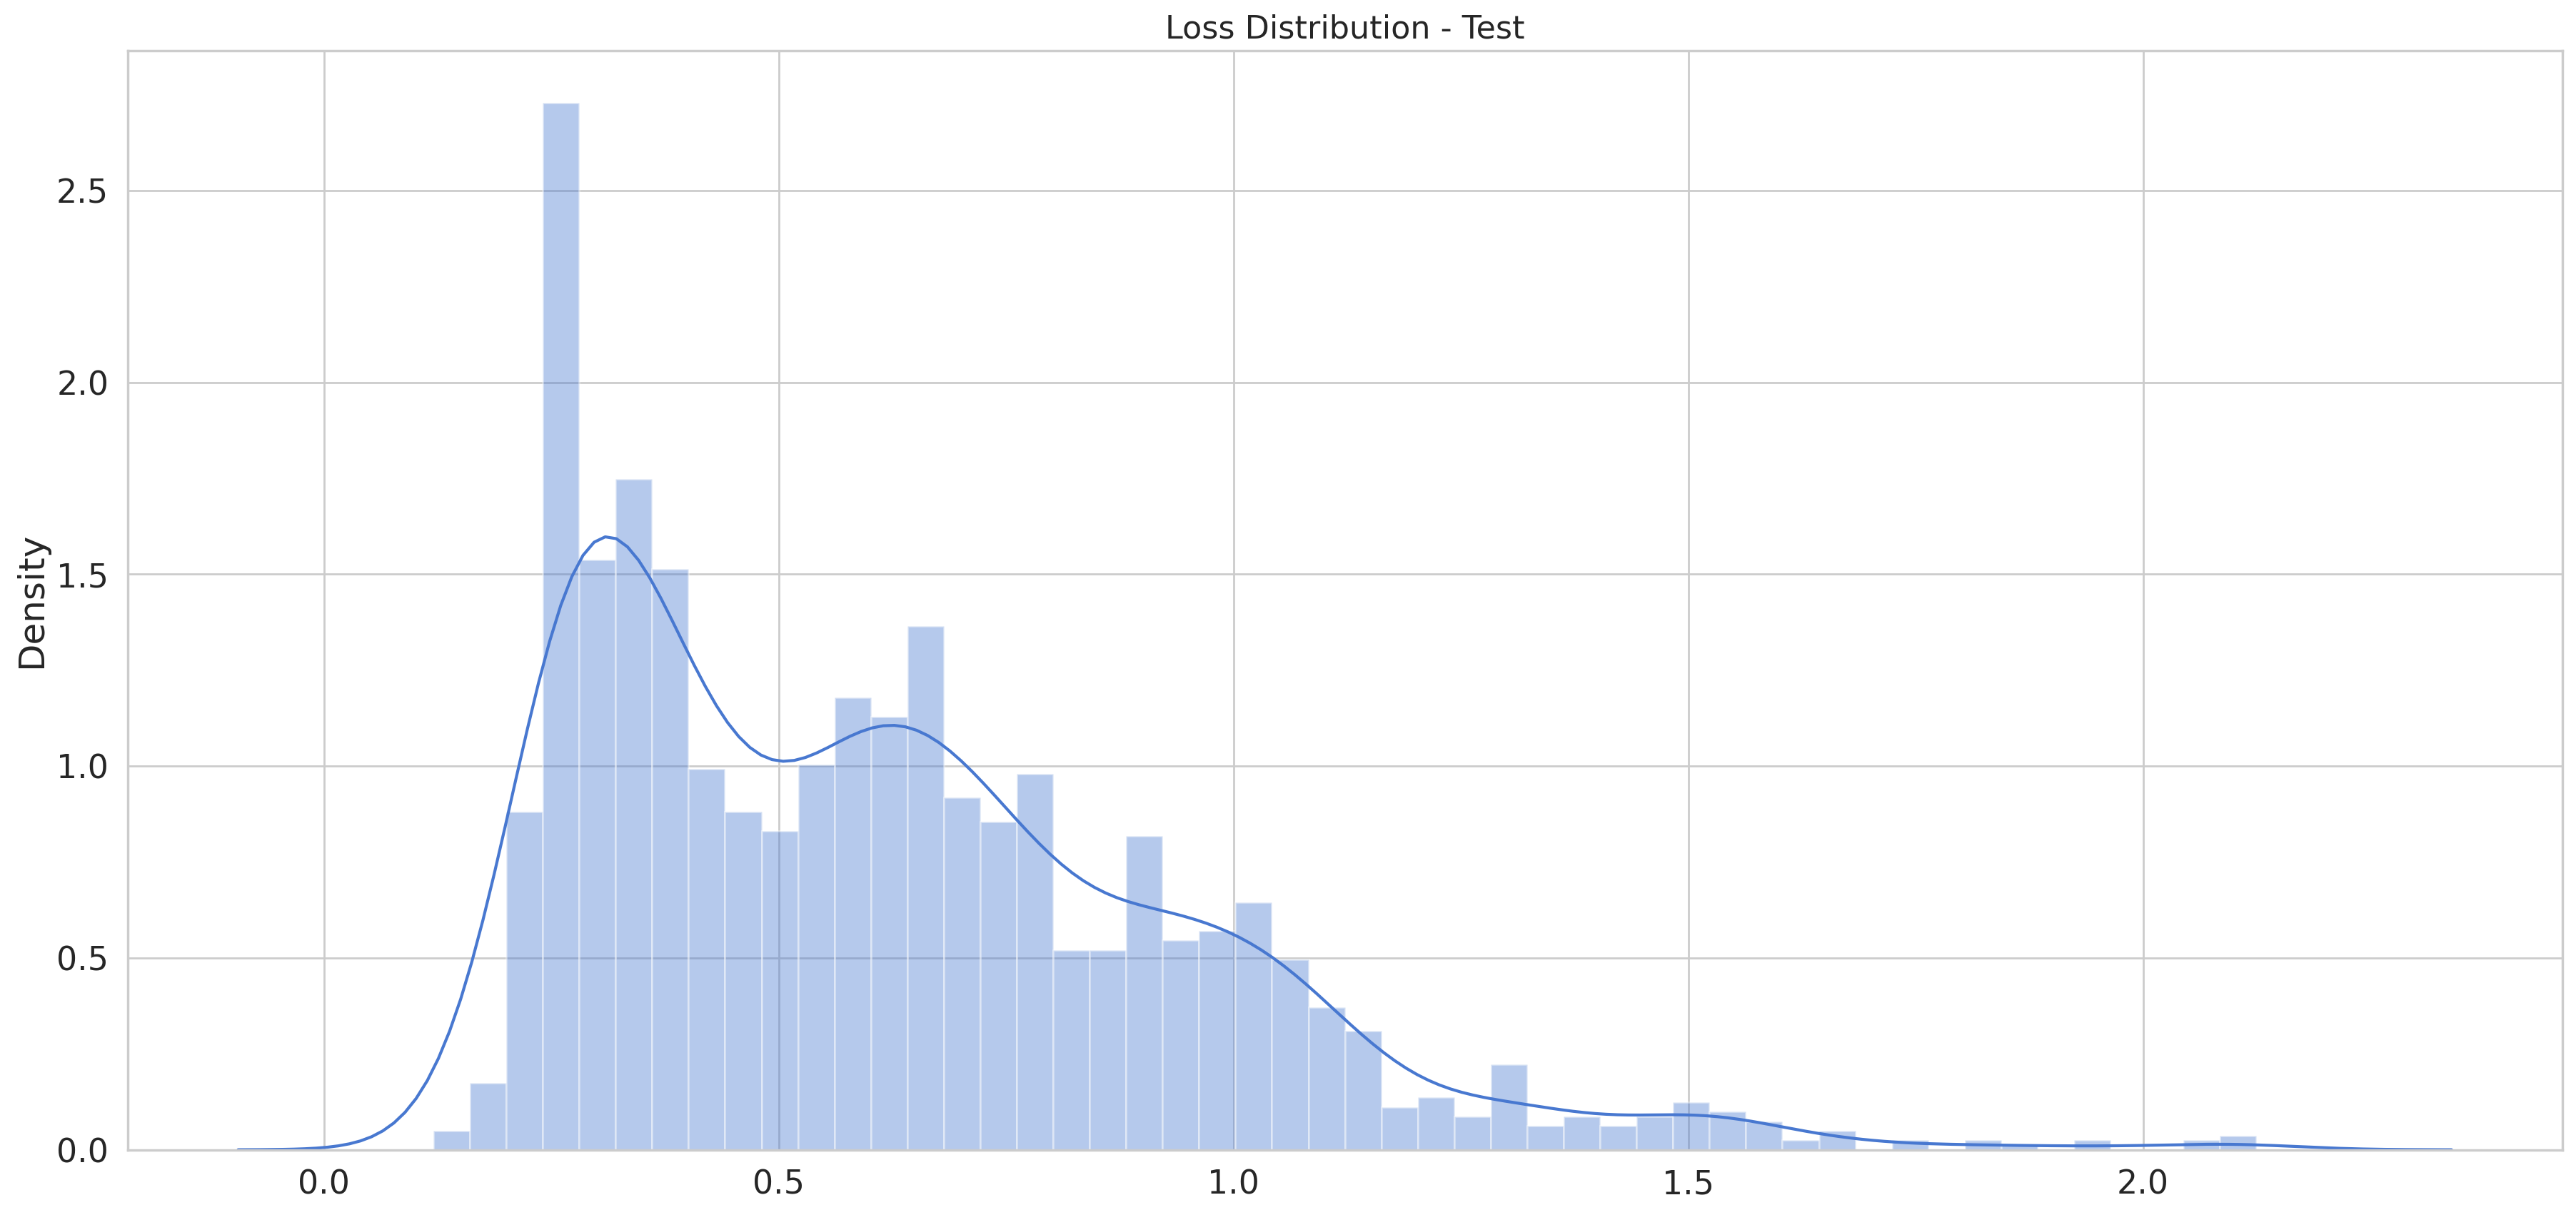

In [ ]:
plt.title('Loss Distribution - Test', fontsize=16)
sns.distplot(test_mae_loss, bins=50, kde=True);

CALC THRESHOLD WITH STD.DEVAITION

In [ ]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

# Compute threshold dynamically
mean_loss = np.mean(test_mae_loss)
std_loss = np.std(test_mae_loss)
THRESHOLD = mean_loss + 2 * std_loss  # Adjust the multiplier as needed

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['Vnavg_V'] = test[TIME_STEPS:].Vnavg_V


63/63 [==============================] - 3s 44ms/step


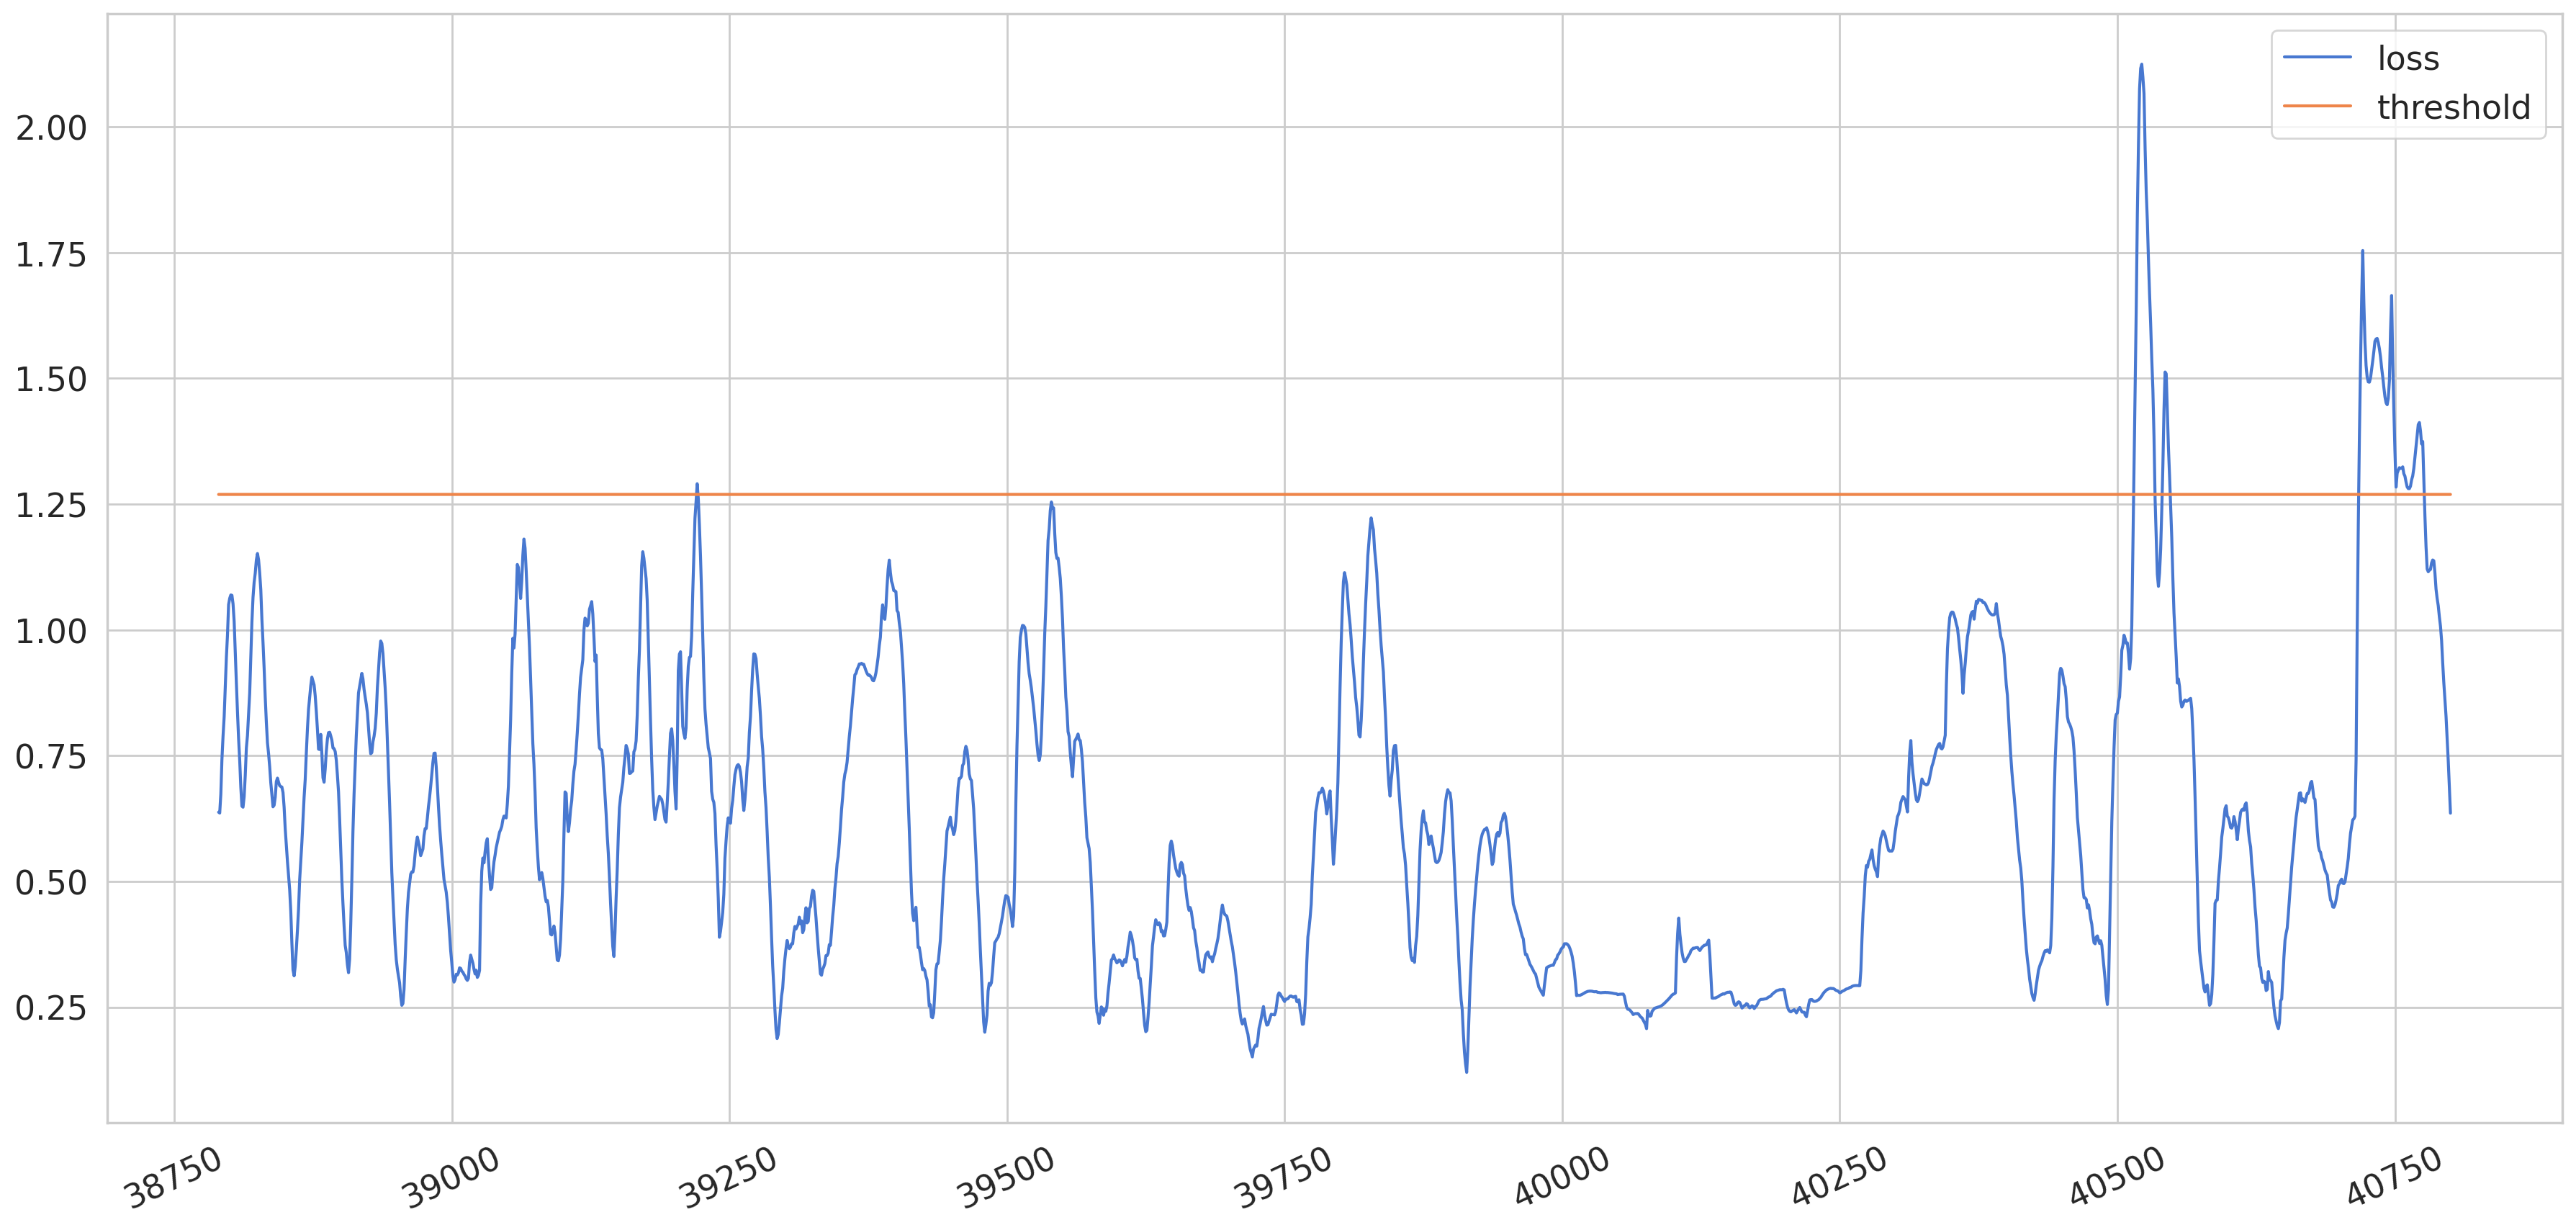

In [ ]:

plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();


In [ ]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()
# len(anomalies)

,loss,threshold,anomaly,Vnavg_V
39221,1.290536,1.269299,True,0.263384
40515,1.320084,1.269299,True,2.580727
40516,1.482765,1.269299,True,2.593106
40517,1.636857,1.269299,True,3.257318
40518,1.825683,1.269299,True,3.076155


In [ ]:
test

,Time,Vnavg_V
38760,2023-03-21 07:00:00,0.847841
38761,2023-03-21 07:30:00,0.389036
38762,2023-03-21 08:00:00,-0.289833
38763,2023-03-21 08:30:00,-0.708463
38764,2023-03-21 09:00:00,-0.860713
...,...,...
40796,2023-05-02 17:00:00,0.542644
40797,2023-05-02 17:30:00,0.634441
40798,2023-05-02 18:00:00,0.546983
40799,2023-05-02 18:30:00,0.601107


In [ ]:
test_score_df

,loss,threshold,anomaly,Vnavg_V
38790,0.637557,1.269299,False,0.599425
38791,0.635909,1.269299,False,0.941415
38792,0.673597,1.269299,False,1.429500
38793,0.742822,1.269299,False,1.439216
38794,0.788595,1.269299,False,1.548457
...,...,...,...,...
40796,0.828560,1.269299,False,0.542644
40797,0.783880,1.269299,False,0.634441
40798,0.739710,1.269299,False,0.546983
40799,0.688877,1.269299,False,0.601107


In [ ]:
merged_df = test.merge(test_score_df, left_index=True, right_index=True)
merged_df

,Time,Vnavg_V_x,loss,threshold,anomaly,Vnavg_V_y
38790,2023-03-21 22:00:00,0.599425,0.637557,1.269299,False,0.599425
38791,2023-03-21 22:30:00,0.941415,0.635909,1.269299,False,0.941415
38792,2023-03-21 23:00:00,1.429500,0.673597,1.269299,False,1.429500
38793,2023-03-21 23:30:00,1.439216,0.742822,1.269299,False,1.439216
38794,2023-03-22 00:00:00,1.548457,0.788595,1.269299,False,1.548457
...,...,...,...,...,...,...
40796,2023-05-02 17:00:00,0.542644,0.828560,1.269299,False,0.542644
40797,2023-05-02 17:30:00,0.634441,0.783880,1.269299,False,0.634441
40798,2023-05-02 18:00:00,0.546983,0.739710,1.269299,False,0.546983
40799,2023-05-02 18:30:00,0.601107,0.688877,1.269299,False,0.601107


In [ ]:
merged_df

,Time,Vnavg_V_x,loss,threshold,anomaly,Vnavg_V_y
38790,2023-03-21 22:00:00,0.599425,0.637557,1.269299,False,0.599425
38791,2023-03-21 22:30:00,0.941415,0.635909,1.269299,False,0.941415
38792,2023-03-21 23:00:00,1.429500,0.673597,1.269299,False,1.429500
38793,2023-03-21 23:30:00,1.439216,0.742822,1.269299,False,1.439216
38794,2023-03-22 00:00:00,1.548457,0.788595,1.269299,False,1.548457
...,...,...,...,...,...,...
40796,2023-05-02 17:00:00,0.542644,0.828560,1.269299,False,0.542644
40797,2023-05-02 17:30:00,0.634441,0.783880,1.269299,False,0.634441
40798,2023-05-02 18:00:00,0.546983,0.739710,1.269299,False,0.546983
40799,2023-05-02 18:30:00,0.601107,0.688877,1.269299,False,0.601107


In [ ]:
import plotly.express as px

def plot_anomaly_scatter(df):
    fig = px.scatter(df.reset_index(), x='Time', y='Vnavg_V_y', color='anomaly', title='Vnavg_V')

    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=2, label="2y", step="year", stepmode="backward"),
                dict(count=3, label="3y", step="year", stepmode="backward"),
                dict(step='all')
            ])
        )
    )
    
    fig.show()


plot_anomaly_scatter(merged_df)

No scaling

In [ ]:
train_size = int(len(dfVnavg_V_30T) * 0.95)
test_size = len(dfVnavg_V_30T) - train_size
train, test = dfVnavg_V_30T.iloc[0:train_size], dfVnavg_V_30T.iloc[train_size:len(dfVnavg_V_30T)]
print(train.shape, test.shape)



def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30

# Create the training and testing datasets without scaling
X_train, y_train = create_dataset(train[['Vnavg_V']], train.Vnavg_V, TIME_STEPS)
X_test, y_test = create_dataset(test[['Vnavg_V']], test.Vnavg_V, TIME_STEPS)

print(X_train.shape)

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=128, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=128, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=200,
    validation_split=0.1,
    shuffle=False
)


(38760, 2) (2041, 2)
(38730, 30, 1)
Epoch 1/10
175/175 [==============================] - 55s 294ms/step - loss: 209.5320 - val_loss: 197.7713
Epoch 2/10
175/175 [==============================] - 51s 289ms/step - loss: 184.6052 - val_loss: 174.5873
Epoch 3/10
175/175 [==============================] - 51s 289ms/step - loss: 161.6602 - val_loss: 151.8054
Epoch 4/10
175/175 [==============================] - 50s 287ms/step - loss: 138.9580 - val_loss: 129.1746
Epoch 5/10
175/175 [==============================] - 51s 290ms/step - loss: 116.3709 - val_loss: 106.6246
Epoch 6/10
175/175 [==============================] - 51s 291ms/step - loss: 93.8428 - val_loss: 84.1226
Epoch 7/10
175/175 [==============================] - 52s 296ms/step - loss: 71.3697 - val_loss: 61.6545
Epoch 8/10
175/175 [==============================] - 53s 303ms/step - loss: 48.8975 - val_loss: 39.2082
Epoch 9/10
175/175 [==============================] - 51s 292ms/step - loss: 26.7688 - val_loss: 17.4731
Epoch 10/

MinMax Scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(train[['Vnavg_V']])
train['Vnavg_V'] = scaler.transform(train[['Vnavg_V']])
test['Vnavg_V'] = scaler.transform(test[['Vnavg_V']])
from sklearn.preprocessing import MinMaxScaler

# Initialize and fit the scaler
scaler = MinMaxScaler()
scaler.fit(train[['Vnavg_V']])

# Scale the training and testing data
train['Vnavg_V'] = scaler.transform(train[['Vnavg_V']])
test['Vnavg_V'] = scaler.transform(test[['Vnavg_V']])

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30

# Create the training and testing datasets without scaling
X_train, y_train = create_dataset(train[['Vnavg_V']], train.Vnavg_V, TIME_STEPS)
X_test, y_test = create_dataset(test[['Vnavg_V']], test.Vnavg_V, TIME_STEPS)

print(X_train.shape)

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=128,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=128, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=200,
    validation_split=0.1,
    shuffle=False
)


(38730, 30, 1)
Epoch 1/10
175/175 [==============================] - 59s 307ms/step - loss: 0.0727 - val_loss: 0.0429
Epoch 2/10
175/175 [==============================] - 52s 296ms/step - loss: 0.0607 - val_loss: 0.0464
Epoch 3/10
175/175 [==============================] - 52s 297ms/step - loss: 0.0585 - val_loss: 0.0438
Epoch 4/10
175/175 [==============================] - 53s 304ms/step - loss: 0.0579 - val_loss: 0.0432
Epoch 5/10
175/175 [==============================] - 53s 301ms/step - loss: 0.0576 - val_loss: 0.0438
Epoch 6/10
175/175 [==============================] - 52s 299ms/step - loss: 0.0574 - val_loss: 0.0448
Epoch 7/10
175/175 [==============================] - 51s 294ms/step - loss: 0.0574 - val_loss: 0.0455
Epoch 8/10
175/175 [==============================] - 52s 295ms/step - loss: 0.0574 - val_loss: 0.0462
Epoch 9/10
175/175 [==============================] - 53s 301ms/step - loss: 0.0575 - val_loss: 0.0468
Epoch 10/10
175/175 [==============================] - 53s

Gradient Clipping, Regularization Batvh Normalization

If you are encountering a loss of nan (Not a Number) during the training of your model, it typically indicates numerical instability or exploding/vanishing gradients. Here are a few steps you can take to address this issue:

* **Check your data**: Make sure your input data does not contain missing values or outliers that could lead to numerical instability. You can perform data preprocessing steps such as data normalization or imputation of missing values to improve the quality of your input data.

* **Adjust learning rate:** An excessively high learning rate can cause the loss to diverge or result in unstable training. Try reducing the learning rate to a smaller value to stabilize the training process. Alternatively, you can use adaptive learning rate techniques, such as learning rate schedules or optimizers like Adam, which automatically adjust the learning rate based on the training progress.

* **Gradient clipping**: If you're using gradient-based optimization algorithms, gradient clipping can help mitigate exploding gradients. By setting a threshold, you can limit the maximum gradient value during the training process. This can be achieved by using the clipvalue or clipnorm parameters in your optimizer.

* **Regularization**: Applying regularization techniques like L1 or L2 regularization (weight decay) can help prevent overfitting and improve numerical stability. Regularization adds a penalty term to the loss function, discouraging large weights and reducing the chances of divergence.

* **Batch normalization**: Implementing batch normalization layers in your model can help stabilize the training process and mitigate the effect of vanishing/exploding gradients. Batch normalization normalizes the input to each layer by adjusting the mean and standard deviation, which can prevent the gradients from becoming too large or too small.

* **Model architecture**: Consider modifying the architecture of your model. You can try reducing the complexity of the model by reducing the number of layers or the number of units in each layer. A simpler model may be more stable during training.

* **Increase training data**: Insufficient training data can sometimes lead to numerical instability. If you have a small dataset, consider augmenting it or obtaining more training samples to improve the generalization and stability of your model.

By implementing these steps, you should be able to address the issue of a loss value of nan during the training of your model. It's also important to monitor the training process closely and experiment with different approaches to find the best combination of techniques for your specific problem.

Standard Scaler

In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers

train_size = int(len(dfVnavg_V_30T) * 0.95)
test_size = len(dfVnavg_V_30T) - train_size
train, test = dfVnavg_V_30T.iloc[0:train_size], dfVnavg_V_30T.iloc[train_size:len(dfVnavg_V_30T)]
print(train.shape, test.shape)


scaler = StandardScaler()
scaler = scaler.fit(train[['Vnavg_V']])

train['Vnavg_V'] = scaler.transform(train[['Vnavg_V']])
test['Vnavg_V'] = scaler.transform(test[['Vnavg_V']])

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train[['Vnavg_V']], train.Vnavg_V, TIME_STEPS)
X_test, y_test = create_dataset(test[['Vnavg_V']], test.Vnavg_V, TIME_STEPS)

print(X_train.shape)

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2]),
    kernel_regularizer=regularizers.l2(0.01),
    recurrent_regularizer=regularizers.l2(0.01),
    bias_regularizer=regularizers.l2(0.01),
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(
    units=64,
    return_sequences=True,
    kernel_regularizer=regularizers.l2(0.01),
    recurrent_regularizer=regularizers.l2(0.01),
    bias_regularizer=regularizers.l2(0.01),
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=200,
    validation_split=0.1,
    shuffle=False,
    callbacks=[keras.callbacks.EarlyStopping(patience=3)],
)


(38760, 2) (2041, 2)
(38730, 30, 1)
Epoch 1/10
175/175 [==============================] - 32s 154ms/step - loss: 2.8617 - val_loss: 1.6656
Epoch 2/10
175/175 [==============================] - 26s 147ms/step - loss: 1.6647 - val_loss: 1.1780
Epoch 3/10
175/175 [==============================] - 26s 149ms/step - loss: 1.2719 - val_loss: 0.9220
Epoch 4/10
175/175 [==============================] - 26s 147ms/step - loss: 1.0518 - val_loss: 0.7604
Epoch 5/10
175/175 [==============================] - 26s 151ms/step - loss: 0.9145 - val_loss: 0.6529
Epoch 6/10
175/175 [==============================] - 27s 154ms/step - loss: 0.8302 - val_loss: 0.5882
Epoch 7/10
175/175 [==============================] - 26s 147ms/step - loss: 0.7799 - val_loss: 0.5507
Epoch 8/10
175/175 [==============================] - 26s 147ms/step - loss: 0.7517 - val_loss: 0.5305
Epoch 9/10
175/175 [==============================] - 26s 146ms/step - loss: 0.7369 - val_loss: 0.5204
Epoch 10/10
175/175 [================

No Scaling

In [ ]:
train_size = int(len(dfVnavg_V_30T) * 0.95)
test_size = len(dfVnavg_V_30T) - train_size
train, test = dfVnavg_V_30T.iloc[0:train_size], dfVnavg_V_30T.iloc[train_size:len(dfVnavg_V_30T)]
print(train.shape, test.shape)



def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30

# Create the training and testing datasets without scaling
X_train, y_train = create_dataset(train[['Vnavg_V']], train.Vnavg_V, TIME_STEPS)
X_test, y_test = create_dataset(test[['Vnavg_V']], test.Vnavg_V, TIME_STEPS)

print(X_train.shape)

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=200,
    validation_split=0.1,
    shuffle=False
)


(38760, 2) (2041, 2)
(38730, 30, 1)
Epoch 1/10
175/175 [==============================] - 30s 148ms/step - loss: 220.0695 - val_loss: 213.9691
Epoch 2/10
175/175 [==============================] - 25s 140ms/step - loss: 206.3165 - val_loss: 201.9031
Epoch 3/10
175/175 [==============================] - 25s 142ms/step - loss: 194.4692 - val_loss: 190.2113
Epoch 4/10
175/175 [==============================] - 25s 141ms/step - loss: 182.8580 - val_loss: 178.6682
Epoch 5/10
175/175 [==============================] - 25s 143ms/step - loss: 171.3636 - val_loss: 167.2064
Epoch 6/10
175/175 [==============================] - 25s 141ms/step - loss: 159.9251 - val_loss: 155.7944
Epoch 7/10
175/175 [==============================] - 25s 141ms/step - loss: 148.5309 - val_loss: 144.4159
Epoch 8/10
175/175 [==============================] - 25s 140ms/step - loss: 137.1567 - val_loss: 133.0601
Epoch 9/10
175/175 [==============================] - 25s 142ms/step - loss: 125.8194 - val_loss: 121.7229
E

MinMax Scalar

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train[['Vnavg_V']])
train['Vnavg_V'] = scaler.transform(train[['Vnavg_V']])
test['Vnavg_V'] = scaler.transform(test[['Vnavg_V']])
from sklearn.preprocessing import MinMaxScaler

# Initialize and fit the scaler
scaler = MinMaxScaler()
scaler.fit(train[['Vnavg_V']])

# Scale the training and testing data
train['Vnavg_V'] = scaler.transform(train[['Vnavg_V']])
test['Vnavg_V'] = scaler.transform(test[['Vnavg_V']])

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30

# Create the training and testing datasets without scaling
X_train, y_train = create_dataset(train[['Vnavg_V']], train.Vnavg_V, TIME_STEPS)
X_test, y_test = create_dataset(test[['Vnavg_V']], test.Vnavg_V, TIME_STEPS)

print(X_train.shape)

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=200,
    validation_split=0.1,
    shuffle=False
)


(38730, 30, 1)
Epoch 1/10
175/175 [==============================] - 33s 159ms/step - loss: 0.0779 - val_loss: 0.0447
Epoch 2/10
175/175 [==============================] - 28s 162ms/step - loss: 0.0620 - val_loss: 0.0463
Epoch 3/10
175/175 [==============================] - 27s 154ms/step - loss: 0.0595 - val_loss: 0.0436
Epoch 4/10
175/175 [==============================] - 27s 152ms/step - loss: 0.0585 - val_loss: 0.0439
Epoch 5/10
175/175 [==============================] - 27s 153ms/step - loss: 0.0581 - val_loss: 0.0456
Epoch 6/10
175/175 [==============================] - 27s 153ms/step - loss: 0.0580 - val_loss: 0.0474
Epoch 7/10
175/175 [==============================] - 27s 152ms/step - loss: 0.0582 - val_loss: 0.0479
Epoch 8/10
175/175 [==============================] - 27s 153ms/step - loss: 0.0581 - val_loss: 0.0475
Epoch 9/10
175/175 [==============================] - 27s 152ms/step - loss: 0.0580 - val_loss: 0.0472
Epoch 10/10
175/175 [==============================] - 27s

Optimizer Function

In [ ]:
from sklearn.preprocessing import StandardScaler

train_size = int(len(dfVnavg_V_30T) * 0.95)
test_size = len(dfVnavg_V_30T) - train_size
train, test = dfVnavg_V_30T.iloc[0:train_size], dfVnavg_V_30T.iloc[train_size:len(dfVnavg_V_30T)]
print(train.shape, test.shape)


scaler = StandardScaler()
scaler = scaler.fit(train[['Vnavg_V']])

train['Vnavg_V'] = scaler.transform(train[['Vnavg_V']])
test['Vnavg_V'] = scaler.transform(test[['Vnavg_V']])
     
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train[['Vnavg_V']], train.Vnavg_V, TIME_STEPS)
X_test, y_test = create_dataset(test[['Vnavg_V']], test.Vnavg_V, TIME_STEPS)

print(X_train.shape)

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=128,  # Reduce the number of units
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=128, return_sequences=True))  # Reduce the number of units
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=0.001))  # Reduce the learning rate

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=200,
    validation_split=0.1,
    shuffle=False
)


(38760, 2) (2041, 2)
(38730, 30, 1)
Epoch 1/10
175/175 [==============================] - 59s 313ms/step - loss: 0.7024 - val_loss: 0.5143
Epoch 2/10
175/175 [==============================] - 54s 309ms/step - loss: 0.6969 - val_loss: 0.5201
Epoch 3/10
175/175 [==============================] - 55s 313ms/step - loss: 0.6961 - val_loss: 0.5237
Epoch 4/10
175/175 [==============================] - 54s 310ms/step - loss: 0.6971 - val_loss: 0.5247
Epoch 5/10
175/175 [==============================] - 53s 304ms/step - loss: 0.6976 - val_loss: 0.5270
Epoch 6/10
175/175 [==============================] - 54s 306ms/step - loss: 0.6971 - val_loss: 0.5778
Epoch 7/10
175/175 [==============================] - 52s 296ms/step - loss: 0.6991 - val_loss: 0.5594
Epoch 8/10
175/175 [==============================] - 51s 294ms/step - loss: 0.6986 - val_loss: 0.5619
Epoch 9/10
175/175 [==============================] - 51s 289ms/step - loss: 0.6982 - val_loss: 0.5618
Epoch 10/10
175/175 [================